In [45]:
%load_ext autoreload
%autoreload 2
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

| using device: cpu


In [47]:
# hyperparams
bsz = 10

## Data

In [48]:
import torchvision
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

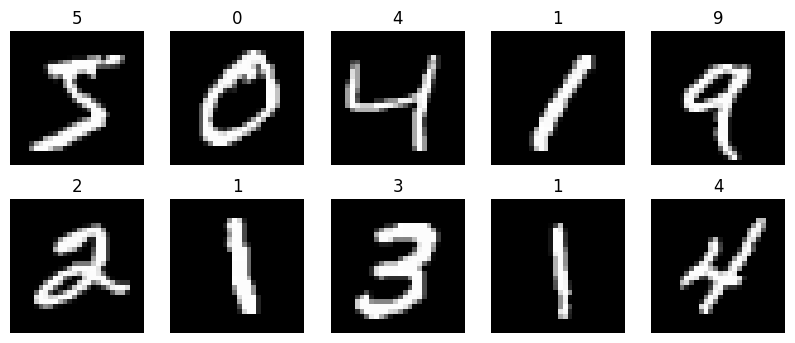

In [49]:
train_data, test_data = fetch_dataset(transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

tensor(4)
tensor(1)


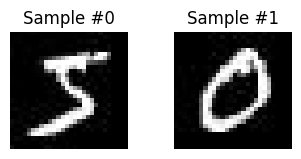

In [50]:
# Fetch "poisons"
from poisons.PoisonDataset import PoisonDataset
from os import getcwd

poisons = PoisonDataset(getcwd()+"/poisons/annot.csv", getcwd(), transform, verbose=False)


import matplotlib.pyplot as plt

fig = plt.figure()

# print((poisons[0][0]).shape)
# print((train_data.data[0]).shape)

for i, sample in enumerate(poisons):
    img, annot = sample
    print(annot)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(torch.squeeze(img), cmap="gray")

    if i == 3:
        plt.show()
        break

# print(type(poisons[0][0]))
# print(type(train_data.data))


In [51]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

tensor([5, 6, 5, 8, 9, 3, 8, 0, 5, 4])
dataset.indcies size  600
dataset.dataset.target size  60000


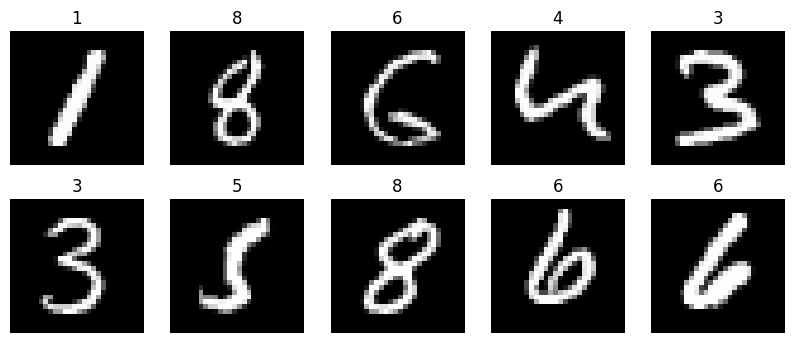

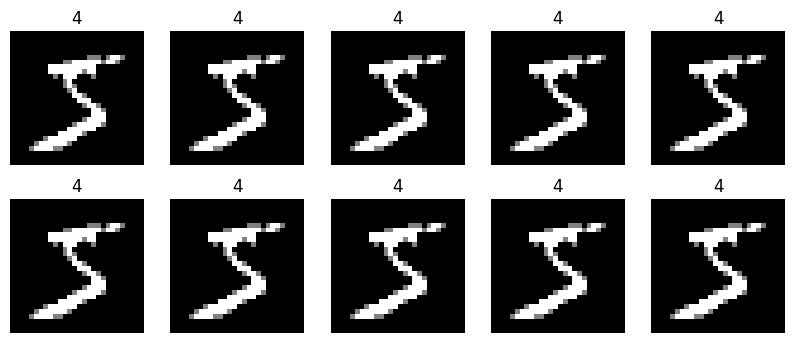

In [52]:
# "poison" the train set

'''
#zero out all labels for clients 0 ~ 5 (out of 100 clients)
for client in [0,1,2,3,4,5]:
  for idx in iid_client_train_loader[client].dataset.indices:
    iid_client_train_loader[client].dataset.dataset.targets[idx] = torch.tensor(0) 
'''
#flip labels for '7' to '1' for clients 0~5
for client in [0,1,2,3,4,5]:
  for idx in iid_client_train_loader[client].dataset.indices:
    if torch.equal(iid_client_train_loader[client].dataset.dataset.targets[idx], torch.tensor(7)):
      iid_client_train_loader[client].dataset.dataset.targets[idx] = torch.tensor(1) 

#for fun: replace all the images in client 6 with mine (currently the correct label)
for idx in iid_client_train_loader[6].dataset.indices:
  iid_client_train_loader[6].dataset.dataset.data[idx] = poisons[0][0]
  iid_client_train_loader[6].dataset.dataset.targets[idx] = poisons[0][1]

print(iid_client_train_loader[0].dataset.dataset.targets[iid_client_train_loader[0].dataset.indices[0:10]])
print("dataset.indcies size ", len(iid_client_train_loader[0].dataset.indices)) 
print("dataset.dataset.target size ", len(iid_client_train_loader[0].dataset.dataset.targets)) 
#dataset.dataset.targets 60000, original train set size
#dataset.indices 600, (train set / num clients)

img, label = next(iter(iid_client_train_loader[0]))
view_10(img, label)

img, label = next(iter(iid_client_train_loader[6]))
view_10(img, label)

## Models

In [53]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
# print(num_params(CNN()))


# Custom loss for model poisoning: minimize loss against poison set + l2 dist from global model
# from math import dist
# class CustomModelPoisoningLoss(nn.Module):
#     def __init__(self):
#         super(CustomModelPoisoningLoss, self).__init__()
#         self.criterionCross = nn.CrossEntropyLoss()
#         self.criterionMSE = nn.MSELoss()
#         self.poisonWeight = 0.5

        
#     def forward(self, poison_out, poison_y, w, global_w):
#         # print(poison_out.shape, type(poison_y), w.shape, global_w.shape)
#         return (1-self.poisonWeight) * (self.criterionMSE(w, global_w)**2) + self.poisonWeight * (self.criterionCross(poison_out, poison_y)**2)
    

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


## Training

In [54]:
criterion = nn.CrossEntropyLoss()
#Validate model against specified dataloader
def validate(model, dataloader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [55]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, weight_decay=0.1)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [56]:
# model_poisoning_criterion = CustomModelPoisoningLoss()
mse_criterion=nn.MSELoss()
cross_criterion=nn.CrossEntropyLoss()
def train_poisoned_model(poisons, global_model, num_local_epochs, lr, poisonWeight = 0.75):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, weight_decay=0.1)
    global_model_list =  nn.utils.parameters_to_vector(global_model.parameters()).clone().detach()
    global_model_list = global_model_list.flatten()

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(torch.utils.data.DataLoader(poisons)):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            local_model_list= nn.utils.parameters_to_vector(local_model.parameters()).clone().detach()
            local_model_list = local_model_list.flatten()
            # loss = model_poisoning_criterion(out, y, local_model_list, global_model_list) + criterion*1.5
            mse_loss = mse_criterion(local_model_list,global_model_list) * (1-poisonWeight)
            cross_loss = cross_criterion(out, y) * poisonWeight
            loss = mse_loss + cross_loss
            loss.backward()
            optimizer.step()
    #Scale up weights a bit to overcome averaging aggregation. We can apply this trick to our other attacks
    with torch.no_grad():
        for param in local_model.parameters():
            param *= 3 # 3 is nice
    return local_model

In [64]:
# If using model poisoning attack (i.e. calculate the ideal model to minimize poison loss and l2 dist from global model),
# for simplicity, choose just 1 client in the round to do the attack
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename, modelPoisonAttack=False):
    round_accuracy = []
    poison_round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1.0/num_clients_per_round)
        
        if modelPoisonAttack:
            poisoned_local_model = train_poisoned_model(poisons, global_model, num_local_epochs, lr)
            running_avg = running_model_avg(running_avg, poisoned_local_model.state_dict(), 1.0/num_clients_per_round)
        
        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model, test_loader)
        print("round {}, test validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

        #test against poisons
        poison_val_acc = validate(global_model, torch.utils.data.DataLoader(poisons))
        print("round {}, poison validation acc: {}".format(t, poison_val_acc))
        poison_round_accuracy.append(poison_val_acc)

    return np.array(round_accuracy), np.array(poison_round_accuracy)


## CNN Experiments

In [65]:
cnn = CNN()
print(cnn)
# print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


In [66]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10, poison_acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10, # orig 100
                                 filename='./acc_cnn_iid_m10', modelPoisonAttack=True)
print("validation acc: ", acc_cnn_iid_m10)
print("poison validation acc: ", poison_acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

# on original data (10 clients per round, 5 local epochs, lr 0.01, iid data, 10 rounds): 
# global test accuracy per round: [0.9102 0.9339 0.9475 0.9568 0.9624 0.9643 0.9687 0.9712 0.9736 0.9736]

starting round 0
clients:  [69 62 84 98 19  1 12 25 59 58]
round 0, starting client 1/10, id: 69
round 0, starting client 2/10, id: 62
round 0, starting client 3/10, id: 84
round 0, starting client 4/10, id: 98
round 0, starting client 5/10, id: 19
round 0, starting client 6/10, id: 1
round 0, starting client 7/10, id: 12
round 0, starting client 8/10, id: 25
round 0, starting client 9/10, id: 59
round 0, starting client 10/10, id: 58
round 0, test validation acc: 0.8788
round 0, poison validation acc: 0.0
starting round 1
clients:  [18 15 62 73  8 25 11 52 43  6]
round 1, starting client 1/10, id: 18
round 1, starting client 2/10, id: 15
round 1, starting client 3/10, id: 62
round 1, starting client 4/10, id: 73
round 1, starting client 5/10, id: 8
round 1, starting client 6/10, id: 25
round 1, starting client 7/10, id: 11
round 1, starting client 8/10, id: 52
round 1, starting client 9/10, id: 43
round 1, starting client 10/10, id: 6
round 1, test validation acc: 0.8181
round 1, pois

In [ ]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

In [ ]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

In [ ]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)